<a href="https://colab.research.google.com/github/fabrihayra/Grocery-Sales-Database/blob/main/Grocery_Sales_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrexibiza/grocery-sales-dataset")

print("Path to dataset files:", path)

100%|██████████| 223M/223M [00:02<00:00, 82.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrexibiza/grocery-sales-dataset/versions/3


In [9]:
import pandas as pd
import os

dataset_path = "/root/.cache/kagglehub/datasets/andrexibiza/grocery-sales-dataset/versions/3"

files = ["sales.csv", "products.csv", "categories.csv", "employees.csv", "customers.csv", "cities.csv", "countries.csv"]
dataframes = {}

for file in files:
    file_path = os.path.join(dataset_path, file)
    df = pd.read_csv(file_path)
    dataframes[file] = df
    print(f"--- {file} ---")
    print(df.head(), "\n")

--- sales.csv ---
   SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
0        1              6       27039        381         7       0.0   
1        2             16       25011         61         7       0.0   
2        3             13       94024         23        24       0.0   
3        4              8       73966        176        19       0.2   
4        5             10       32653        310         9       0.0   

   TotalPrice                SalesDate     TransactionNumber  
0         0.0  2018-02-05 07:38:25.430  FQL4S94E4ME1EZFTG42G  
1         0.0  2018-02-02 16:03:31.150  12UGLX40DJ1A5DTFBHB8  
2         0.0  2018-05-03 19:31:56.880  5DT8RCPL87KI5EORO7B0  
3         0.0  2018-04-07 14:43:55.420  R3DR9MLD5NR76VO17ULE  
4         0.0  2018-02-12 15:37:03.940  4BGS0Z5OMAZ8NDAFHHP3   

--- products.csv ---
   ProductID                 ProductName    Price  CategoryID   Class  \
0          1         Flour - Whole Wheat  74.2988           3  Medium   
1 

# Observations & Initial Insights


---


**Based on the dataset preview, here are key takeaways:**

> Sales Data Issues:

* *TotalPrice* is **0.0** for all rows—this might indicate **missing or incorrectly calculated sales values.**
* We have fields for **SalesPersonID, CustomerID, ProductID, Quantity, Discount, and SalesDate**, which are crucial for our analysis.

> Product & Category Information:

* *products.csv* contains **ProductID, CategoryID, Price, and Class.**
* *categories.csv* maps **CategoryID to CategoryName.**
* *ModifyDate, Resistant, IsAllergic, VitalityDays* exist but may not be useful for supply chain/logistics.

> Employee & Customer Data:

* *employees.csv* contains **EmployeeID, BirthDate, Gender, CityID, and HireDate** (useful for workforce analysis).
* *customers.csv* contains **CustomerID, FirstName, LastName, CityID, Address** (useful for sales segmentation).

> Location Data:

* *cities.csv* links **CityID to CityName, Zipcode, and CountryID.**
* *countries.csv* maps **CountryID to CountryName and CountryCode.**

In [10]:
# Check for missing values
for file, df in dataframes.items():
    print(f"Missing values in {file}:\n", df.isnull().sum(), "\n")

# Check for duplicate rows
for file, df in dataframes.items():
    print(f"Duplicate rows in {file}: {df.duplicated().sum()}\n")

Missing values in sales.csv:
 SalesID                  0
SalesPersonID            0
CustomerID               0
ProductID                0
Quantity                 0
Discount                 0
TotalPrice               0
SalesDate            67526
TransactionNumber        0
dtype: int64 

Missing values in products.csv:
 ProductID       0
ProductName     0
Price           0
CategoryID      0
Class           0
ModifyDate      0
Resistant       0
IsAllergic      0
VitalityDays    0
dtype: int64 

Missing values in categories.csv:
 CategoryID      0
CategoryName    0
dtype: int64 

Missing values in employees.csv:
 EmployeeID       0
FirstName        0
MiddleInitial    0
LastName         0
BirthDate        0
Gender           0
CityID           0
HireDate         0
dtype: int64 

Missing values in customers.csv:
 CustomerID         0
FirstName          0
MiddleInitial    977
LastName           0
CityID             0
Address            0
dtype: int64 

Missing values in cities.csv:
 CityID   

# Handling Missing Sales Dates

**Issue:**

*(67526 missing values)*

1. **SalesDate** is missing for **67,526** rows in **sales.csv**, which is critical for time-based analysis.

**Solution Options:**
Analyzing database and its variables.
If *SalesDate* is missing at random: Drop those rows.
If patterns exist: Use customer, product, or transaction trends to estimate missing dates.

2. Recalculating **TotalPrice** in sales.csv.

Since TotalPrice is 0 for all transactions, we should recalculate it.

3. Handling **Missing Country Codes** (1 missing)

**Solution:** Find the missing country using CountryID, then manually update.

In [14]:
print(dataframes["sales.csv"]["SalesDate"].isnull().sum())  # Count missing values in SalesDate column
print(dataframes["sales.csv"].dtypes)  # Check data types of columns in sales DataFrame

67526
SalesID                int64
SalesPersonID          int64
CustomerID             int64
ProductID              int64
Quantity               int64
Discount             float64
TotalPrice           float64
SalesDate             object
TransactionNumber     object
dtype: object


In [17]:
# Converting SalesDate to datetime format
dataframes["sales.csv"]["SalesDate"] = pd.to_datetime(dataframes["sales.csv"]["SalesDate"], errors="coerce")

# Verify conversion
print(dataframes["sales.csv"].dtypes)  # SalesDate should now be datetime64[ns]
print(dataframes["sales.csv"]["SalesDate"].head())  # Check if values look correct

SalesID                       int64
SalesPersonID                 int64
CustomerID                    int64
ProductID                     int64
Quantity                      int64
Discount                    float64
TotalPrice                  float64
SalesDate            datetime64[ns]
TransactionNumber            object
dtype: object
0   2018-02-05 07:38:25.430
1   2018-02-02 16:03:31.150
2   2018-05-03 19:31:56.880
3   2018-04-07 14:43:55.420
4   2018-02-12 15:37:03.940
Name: SalesDate, dtype: datetime64[ns]


> 2. Recalculating TotalPrice

In [23]:
sales_df = sales_df.merge(products_df[["ProductID", "Price"]], on="ProductID")
sales_df["TotalPrice"] = sales_df["Quantity"] * sales_df["Price"] * (1 - sales_df["Discount"])

AttributeError: 'str' object has no attribute 'merge'

In [26]:
print(type(dataframes['sales.csv']))  # Should return <class 'pandas.core.frame.DataFrame'>
print(type(dataframes['products.csv']))  # Should return <class 'pandas.core.frame.DataFrame'>

<class 'str'>
<class 'pandas.core.frame.DataFrame'>


In [27]:
import pandas as pd

dataset_path = "/root/.cache/kagglehub/datasets/andrexibiza/grocery-sales-dataset/versions/3"

# Reloading sales.csv properly
sales_df = pd.read_csv(f"{dataset_path}/sales.csv")

# Verifying it's now a DataFrame
print(type(sales_df))  # Should return <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>


In [30]:
products_df = dataframes["products.csv"]  # Ensure products_df is correct

sales_df = sales_df.merge(products_df[["ProductID", "Price"]], on="ProductID", how="left")

# Recalculate TotalPrice
sales_df["TotalPrice"] = sales_df["Quantity"] * sales_df["Price"] * (1 - sales_df["Discount"])

print(sales_df.head())  # Verify the merge worked

   SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
0        1              6       27039        381         7       0.0   
1        2             16       25011         61         7       0.0   
2        3             13       94024         23        24       0.0   
3        4              8       73966        176        19       0.2   
4        5             10       32653        310         9       0.0   

   TotalPrice                SalesDate     TransactionNumber  Price_x  \
0   309.63590  2018-02-05 07:38:25.430  FQL4S94E4ME1EZFTG42G  44.2337   
1   437.82200  2018-02-02 16:03:31.150  12UGLX40DJ1A5DTFBHB8  62.5460   
2  1896.44160  2018-05-03 19:31:56.880  5DT8RCPL87KI5EORO7B0  79.0184   
3  1236.01384  2018-04-07 14:43:55.420  R3DR9MLD5NR76VO17ULE  81.3167   
4   719.80200  2018-02-12 15:37:03.940  4BGS0Z5OMAZ8NDAFHHP3  79.9780   

   Price_y    Price  
0  44.2337  44.2337  
1  62.5460  62.5460  
2  79.0184  79.0184  
3  81.3167  81.3167  
4  79.9780  79.978

> Rounding numbers

In [38]:
sales_df[["Price","Price_x", "Price_y", "TotalPrice"]].round(2)
print(sales_df.head())

   SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
0        1              6       27039        381         7       0.0   
1        2             16       25011         61         7       0.0   
2        3             13       94024         23        24       0.0   
3        4              8       73966        176        19       0.2   
4        5             10       32653        310         9       0.0   

   TotalPrice                SalesDate     TransactionNumber  Price_x  \
0      309.64  2018-02-05 07:38:25.430  FQL4S94E4ME1EZFTG42G  44.2337   
1      437.82  2018-02-02 16:03:31.150  12UGLX40DJ1A5DTFBHB8  62.5460   
2     1896.44  2018-05-03 19:31:56.880  5DT8RCPL87KI5EORO7B0  79.0184   
3     1236.01  2018-04-07 14:43:55.420  R3DR9MLD5NR76VO17ULE  81.3167   
4      719.80  2018-02-12 15:37:03.940  4BGS0Z5OMAZ8NDAFHHP3  79.9780   

   Price_y  Price  
0      0.0  44.23  
1      0.0  62.55  
2      0.0  79.02  
3      0.2  81.32  
4      0.0  79.98  


> 3. Handling missing country code

In [40]:
countries_df = dataframes["countries.csv"]
missing_country = countries_df[countries_df["CountryCode"].isnull()]
print(missing_country)  # Identifying the country with missing code

     CountryID CountryName CountryCode
145        146   Australia         NaN


In [41]:
# Filling the missing CountryCode for Australia
countries_df.loc[countries_df["CountryID"] == 146, "CountryCode"] = "AU"

In [42]:
print(countries_df[countries_df["CountryID"] == 146])

     CountryID CountryName CountryCode
145        146   Australia          AU


In [49]:
print(type(dataframes["sales.csv"]))  # Should return <class 'pandas.core.frame.DataFrame'>

<class 'str'>


In [50]:
dataframes["sales.csv"] = pd.read_csv(f"{dataset_path}/sales.csv")
print(type(dataframes["sales.csv"]))  # Should now return <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>


In [51]:
# Ensuring correct references
sales_df = dataframes["sales.csv"]
customers_df = dataframes["customers.csv"]

# Saving the cleaned datasets
sales_df.to_csv("cleaned_sales.csv", index=False)
customers_df.to_csv("cleaned_customers.csv", index=False)
countries_df.to_csv("cleaned_countries.csv", index=False)

print("Cleaned data saved successfully!")


Cleaned data saved successfully!


# Supply Chain Analysis
**Goal:** Understand inventory, demand, and supplier efficiency
We’ll start by answering key supply chain questions:

1. **Identify Top-Selling Products (Demand Analysis)**

Which products are selling the most?
Which categories are performing best?

In [54]:
import matplotlib.pyplot as plt

# Aggregating total quantity sold per product
top_products = sales_df.groupby("ProductID")["Quantity"].sum().reset_index()

# Merging with product details
top_products = top_products.merge(products_df[["ProductID", "ProductName"]], on="ProductID")

# Sorting by highest sales
top_products = top_products.sort_values(by="Quantity", ascending=False).head(10)

print(top_products)

     ProductID  Quantity              ProductName
178        179    199724            Yoghurt Tubes
160        161    199679   Longos - Chicken Wings
46          47    198567     Thyme - Lemon, Fresh
279        280    198163             Onion Powder
102        103    198126          Cream Of Tartar
323        324    198032         Apricots - Dried
38          39    198032               Dried Figs
318        319    198005   Towels - Paper / Kraft
424        425    197969  Wine - Redchard Merritt
183        184    197942            Hersey Shakes


Since all values are very close, the default Matplotlib settings make them appear identical. To fix this, we will adjust the X-axis range to make small differences more visible:

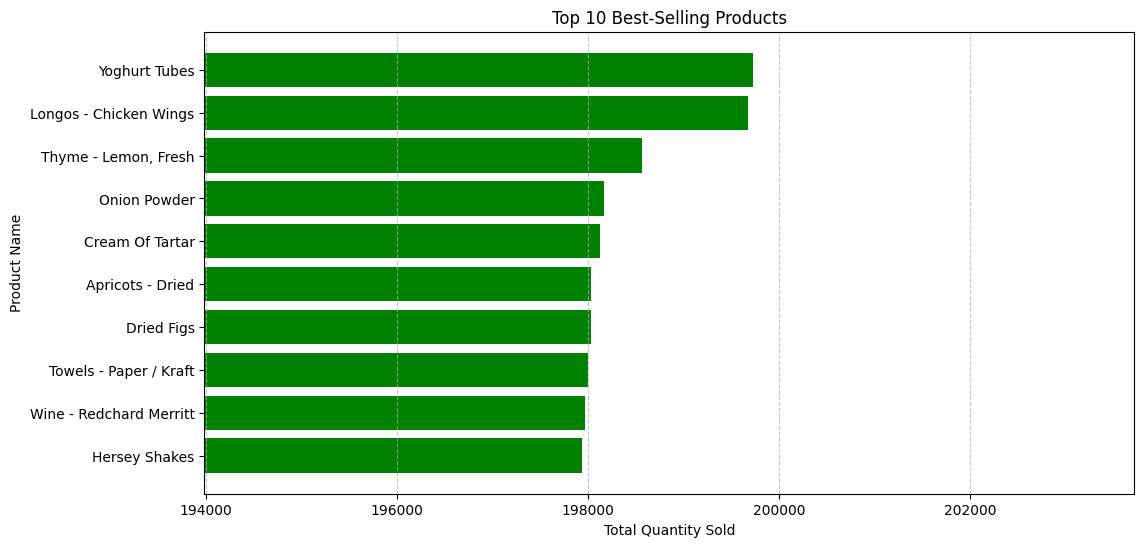

In [61]:
plt.figure(figsize=(12, 6))  # Setting a wider figure size for clarity

# Plotting horizontal bar chart
plt.barh(top_products["ProductName"], top_products["Quantity"], color="green")

plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Name")
plt.title("Top 10 Best-Selling Products")

# Adjusting X-axis to make small differences noticeable
plt.xlim(top_products["Quantity"].min() * 0.98, top_products["Quantity"].max() * 1.02)

# Adding grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Keeping the highest-selling product at the top
plt.gca().invert_yaxis()

plt.show()


> Solution 2: Showing it as percentage difference:

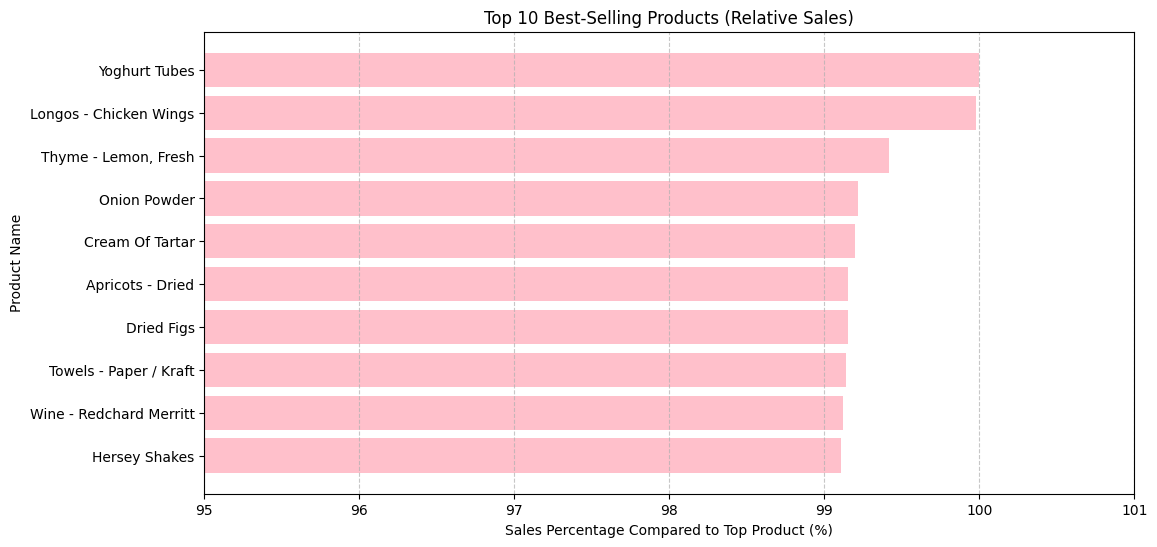

In [59]:
# Normalizing values as percentages of the top-selling product
top_products["SalesPercentage"] = (top_products["Quantity"] / top_products["Quantity"].max()) * 100

plt.figure(figsize=(12, 6))
plt.barh(top_products["ProductName"], top_products["SalesPercentage"], color="pink")

plt.xlabel("Sales Percentage Compared to Top Product (%)")
plt.ylabel("Product Name")
plt.title("Top 10 Best-Selling Products (Relative Sales)")

plt.xlim(95, 101)  # Showing only relevant percentage differences
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()

plt.show()

# Top 10 Best-Selling Products analysis reveals:

- Small percentage differences between the best-sellers, meaning **demand is fairly even across the top products.**
- **Yoghurt Tubes & Longos Chicken Wings** are the top two, but only slightly ahead of the rest.
- **Dried fruits, seasonings, and beverages make up a significant portion of top sales**, suggesting that packaged and non-perishable goods are in high
demand.


### **This is valuable because:**
> Inventory Planning → Ensuring stock levels are managed for these high-demand products.

> Marketing & Promotions → These products can be highlighted in promotions.

> Logistics Optimization → Warehouses should prioritize quick restocking of these items.

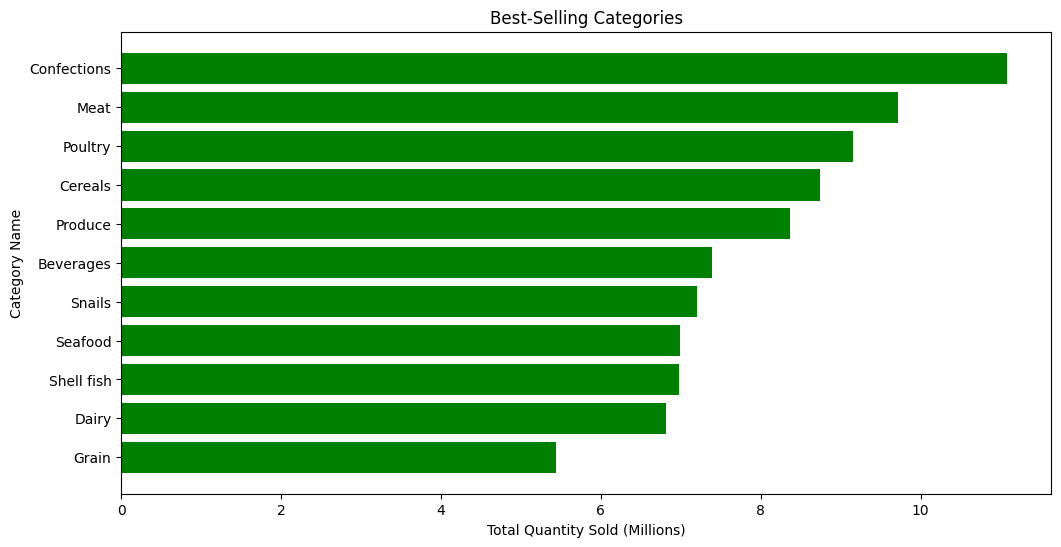

In [65]:
# Merging sales with product details to get category info
sales_with_products = sales_df.merge(products_df[["ProductID", "CategoryID"]], on="ProductID")

# Merging with categories dataset to get category names
sales_with_categories = sales_with_products.merge(dataframes['categories.csv'], on="CategoryID")

# Aggregating total quantity sold per category
category_sales = sales_with_categories.groupby("CategoryName")["Quantity"].sum().reset_index()

# Sorting by highest sales
category_sales = category_sales.sort_values(by="Quantity", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(category_sales["CategoryName"], category_sales["Quantity"] / 1_000_000, color="green")

plt.xlabel("Total Quantity Sold (Millions)")
plt.ylabel("Category Name")
plt.title("Best-Selling Categories")

plt.gca().invert_yaxis()
plt.show()


# 🔍 Insights & Business Implications
1. **Inventory & Supply Chain Planning**

High demand for Confections, Meat, and Poultry means priority stocking and supplier management are needed.
Produce and Dairy have lower sales, which could indicate perishable nature leading to lower inventory turnover.

2. **Marketing & Promotions**

Confections being the best-seller suggests strong consumer demand for snacks and sweets — ideal for seasonal promotions.
Beverages and Cereals are steady sellers, meaning bundling strategies with top products could work.

3. **Logistics & Distribution**

Meat and Poultry being high-selling means cold chain logistics must be optimized to prevent spoilage.
However, shellfish and Seafood have lower sales, possibly due to higher costs, perishability, or regional demand differences.
